# Fuzzy Logic Inference
** textbook question 7.5 (page 143) as example **

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

## Given

In [2]:
A1 = np.array([0.0, 1.0, 0.6])
B = np.array([0.2, 0.8])

## Rule "If V is A1 then W is B" translates into
Using Eq7.6 of "Correlation Product" on page 130

In [3]:
Rule = np.outer(A1, B) # same as just taking outer product
print(Rule)

[[ 0.    0.  ]
 [ 0.2   0.8 ]
 [ 0.12  0.48]]


** Another e.g. **
If question was asking for "Correlation Min", instead, rule would've been translated into

In [4]:
np.array([min(i,j) for i in A1 for j in B]).reshape(3,2) # kinda like outer product but with 'min' as operator

array([[ 0. ,  0. ],
       [ 0.2,  0.8],
       [ 0.2,  0.6]])

**Side note** Surely there's a vectorized way of doing this:

In [5]:
np.minimum(A1[...,np.newaxis], B[np.newaxis,...])

array([[ 0. ,  0. ],
       [ 0.2,  0.8],
       [ 0.2,  0.6]])

**Side note** Not familiar with matlab, but I might do something like this:

In [6]:
repmat = lambda M,m,n: np.tile(M,(m,n))
_A1 = repmat(A1.reshape(3,1),1,2)
_B = repmat(B.reshape(1,2),3,1)
np.minimum(_A1, _B)

array([[ 0. ,  0. ],
       [ 0.2,  0.8],
       [ 0.2,  0.6]])

** Another e.g. ** And if according to Lukasiewicz's implication, the rule would've become

In [7]:
np.array([min(1.,1-i+j) for i in A1 for j in B]).reshape(3,2)

array([[ 1. ,  1. ],
       [ 0.2,  0.8],
       [ 0.6,  1. ]])

## If "V is A1" was also a known fact, then we'd have
Using Eq7.8 on page 131

In [8]:
""" Conclusion = [sup(min(0,0) min(1,0.2) min(0.6,0.12)) sup(min(0,0) min(1,0.8) min(0.6,0.48))]
    = [sup(0 0.2 0.12) sup(0 0.8 0.48)]
    = [0.2 0.8]
    = B
"""

print('min:',np.minimum(A1[...,np.newaxis],Rule)) # Taking elementwise minimum of A1 with each column in Rule
print('sup:',np.max(np.minimum(A1[...,np.newaxis],Rule), axis=0)) # Taking supremum on each column

min: [[ 0.    0.  ]
 [ 0.2   0.8 ]
 [ 0.12  0.48]]
sup: [ 0.2  0.8]


Recall the value of B, and one could find that the conclusion is **exactly** B (due to fact is exactly A1)

In [9]:
B

array([ 0.2,  0.8])

So this whole calculation reads "**If V is A1 then W is B** and **V is A1** as a matter of fact, so we obtain **W is B**"

## But what if "V is NOT A1"
Just take A1's complement instead:

In [10]:
np.max(np.minimum((1-A1)[...,np.newaxis],Rule), axis=0)

array([ 0.12,  0.4 ])

This concludes the revisit of question 7.5

And the general framework of fuzzy logic inference includes the following steps (page 133 and 134):

(see also [Fuzzy Inference Process](https://www.mathworks.com/help/fuzzy/fuzzy-inference-process.html))

1. Cylindrical closure of antecedents (join together all conditions using cartesian product)
2. Compute implication relation (question 7.5)
3. Draw conclusions with compusitional rule of inference (question 7.5)
4. Conclusion aggregation (question 7.2)
5. Defuzzification

Here's an example:

# A fuzzy control vacuum cleaner

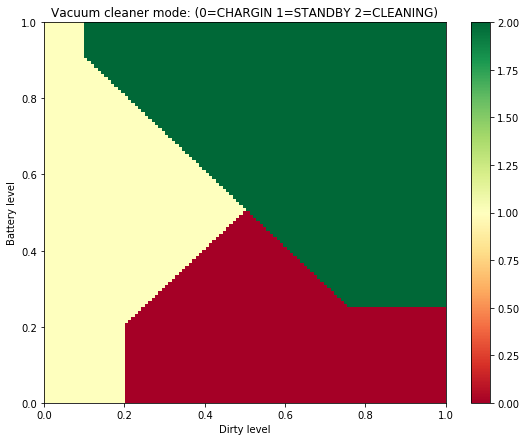

In [11]:
# Input
dirty_level = dict(DIRTY = np.array([.25, .75]),
                   MEDIUM = np.array([.8, .2]),
                   CLEAN = np.array([.95, .5]))

battery_level = dict(HIGH = np.array([.1, .9]),
                     LOW = np.array([.8, .2]))

# Output
mode = dict(CLEANING = np.array([0.0,0.0,1.0]),
            STANDBY = np.array([0.0,1.0,0.0]),
            CHARGING = np.array([1.0,0.0,0.0]))

# Fuzzify a real value into a normal fuzzy number
fuzzify = lambda x: np.array([1.0-x, x])

# Cylindrical closure (just cartesian product of features)
closure = lambda *x: np.concatenate(x)

# Fuzzy inference formular
conclusion = lambda rule, *features: np.max(np.minimum(closure(*features)[...,np.newaxis],rule), axis=0)

# Rules
whatever = np.empty(0) # Irrelevant feature placeholder
new_rule = lambda dirty, battery, mode: np.outer(closure(dirty, battery), mode) # Correlation product

Rules = [
    [ new_rule(dirty_level['DIRTY'],battery_level['HIGH'],mode['CLEANING']),
      new_rule(dirty_level['MEDIUM'],battery_level['HIGH'],mode['CLEANING'])],
    [ new_rule(whatever, battery_level['LOW'], mode['CHARGING']) ],
    [ new_rule(dirty_level['CLEAN'], whatever, mode['STANDBY']) ]
]

def fuzzy_control1(dirty, battery):
    d = fuzzify(dirty)
    b = fuzzify(battery)
    
    # Draw conclusions
    conclusions = []
    for rule in Rules[0]:
        conclusions.append(conclusion(rule,d,b))
    for rule in Rules[1]:
        conclusions.append(conclusion(rule,b))
    for rule in Rules[2]:
        conclusions.append(conclusion(rule,d))
        
    # Max aggregation
    aggregated_conclusion = np.max(conclusions, axis = 0)
    
    # Defuzzification
    return np.argmax(aggregated_conclusion)

def plot(fuzzy_control):
    dirty = np.linspace(0., 1., 120) 
    battery = np.linspace(0., 1., 120) 
    X, Y = np.meshgrid(dirty, battery) 
    Z = np.vectorize(fuzzy_control)(X, Y)
    plt.figure(figsize=(9,7))
    plt.title('Vacuum cleaner mode: (0=CHARGIN 1=STANDBY 2=CLEANING)')
    plt.xlabel('Dirty level')
    plt.ylabel('Battery level')
    plt.pcolormesh(X, Y, Z, cmap='RdYlGn')
    plt.colorbar()
    
plot(fuzzy_control1)

# MA v. TSK

![Sugeno FIS](http://www.cs.princeton.edu/courses/archive/fall07/cos436/HIDDEN/Knapp/gfuzzy/fuzzy009.gif)

references:

1. https://www.mathworks.com/help/fuzzy/what-is-sugeno-type-fuzzy-inference.html
2. https://www.mathworks.com/help/fuzzy/comparison-of-sugeno-and-mamdani-systems.html
3. http://www.cs.princeton.edu/courses/archive/fall07/cos436/HIDDEN/Knapp/fuzzy004.htm
4. Textbook page 137

**Advantages of the Sugeno Method (TSK)**

+ It is computationally efficient.
+ It works well with linear techniques (e.g., PID control).
+ It works well with optimization and adaptive techniques.
+ It has guaranteed continuity of the output surface.
+ It is well suited to mathematical analysis.

**Advantages of the Mamdani Method (MA)**

+ It is intuitive.
+ It has widespread acceptance.
+ It is well suited to human input.


# So how to turn MA into TSK logic?

Now it's more suited to take membership values instead of fuzzy numbers as input.

This is an example membership function, projecting fuzzified input onto linguistic values in the rule in order to see how well they match up.

In [112]:
def membership_func(fuzzy):
    """Create a membership function based on some linguistic value"""
    if np.array_equal(fuzzy, whatever): return lambda x: 1.0 # irrelevant feature
    else: return lambda x: np.dot(fuzzy, fuzzify(x))

## Define TSK rules

In [127]:
def sugeno_rule(dirty, battery, action_weights):
    """Takes linguistic values and actions weights
    returns 2 functions: rule strength and action"""
    
    # Membership functions
    m_dirty = membership_func(dirty)
    m_battery = membership_func(battery)
    
    def strength(dirty_value, battery_value):
        """Takes crisp value and tells you strength of the rule"""
        return np.min([m_dirty(dirty_value), m_battery(battery_value)])
    
    W, b = action_weights
    action = lambda *crisp_features: np.dot(W,np.array(crisp_features))+b
    return strength, action

Rules2 = [
    sugeno_rule(dirty_level['DIRTY'],battery_level['HIGH'], ([1,1],0)), # CLEANING
    sugeno_rule(dirty_level['MEDIUM'],battery_level['HIGH'], ([1,1],0)), # CLEANING
    sugeno_rule(whatever, battery_level['LOW'], ([0.0,-1],0)), # CHARGING
    sugeno_rule(dirty_level['CLEAN'], whatever, ([-1,0.0],0)) # STANDBY
]

## Check rules' firing strength

This only depends on antecedents.

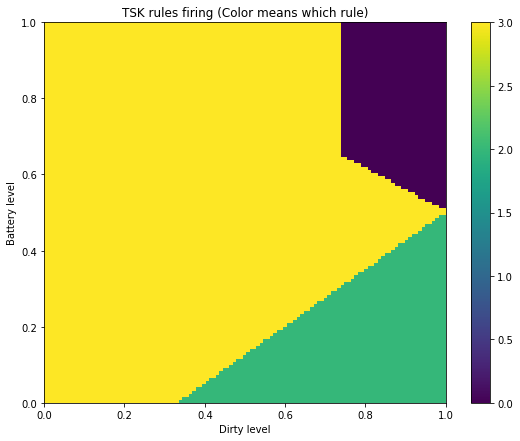

In [128]:
def argmax_strengths(dirty, battery):
    strengths = np.array([strength(dirty, battery) for (strength, action) in Rules2])
    return np.argmax(strengths)

def plot_Rules2():
    dirty = np.linspace(0., 1., 120) 
    battery = np.linspace(0., 1., 120) 
    X, Y = np.meshgrid(dirty, battery) 
    Z = np.vectorize(argmax_strengths)(X, Y)
    plt.figure(figsize=(9,7))
    plt.title('TSK rules firing (Color means which rule)')
    plt.xlabel('Dirty level')
    plt.ylabel('Battery level')
    plt.pcolormesh(X, Y, Z)
    plt.colorbar()

plot_Rules2()

Looks like Rules2[1] is redundant because its firing strength never became too significant. Let's remove it.

In [129]:
Rules2 = [
    sugeno_rule(dirty_level['DIRTY'],battery_level['HIGH'], ([1,1],0)), # CLEANING
    sugeno_rule(whatever, battery_level['LOW'], ([0.0,-1],0)), # CHARGING
    sugeno_rule(dirty_level['CLEAN'], whatever, ([-1,0.0],0)) # STANDBY
]

## TSK fuzzy control

Actions are a linear combination of inputs in this example, but can be any function.

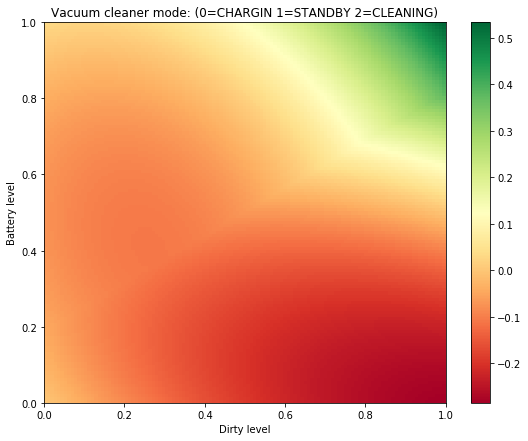

In [130]:
def fuzzy_control2(dirty, battery):
    strengths = np.array([strength(dirty, battery) for (strength, action) in Rules2])
    actions = np.array([action(dirty, battery) for (strength, action) in Rules2])
    return np.dot(strengths, actions)/np.sum(strengths) # No need to defuzzify

plot(fuzzy_control2)

## Fine-tune rules

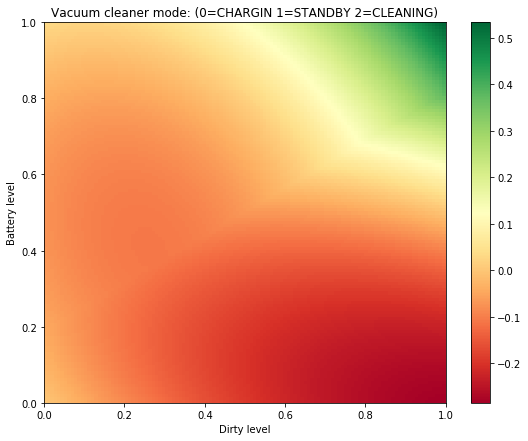

In [131]:
Rules2 = [
    sugeno_rule(dirty_level['DIRTY'],battery_level['HIGH'], ([1,1],0)), # CLEANING
    sugeno_rule(whatever, battery_level['LOW'], ([0.0,-1],0)), # CHARGING
    sugeno_rule(dirty_level['CLEAN'], whatever, ([-1,0.0],0)) # STANDBY
]

plot(fuzzy_control2)